In [1]:
from __future__ import print_function
import ipywidgets as ipyw
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython
import warnings
warnings.filterwarnings("ignore")
import ouu_freyberg


noptmax: 1
                                obsnme    obsval    weight       obgnme  \
obsnme                                                                    
ucn_00_008_015_001  ucn_00_008_015_001  0.065985  0.151310  less_wlconc   
ucn_00_010_012_001  ucn_00_010_012_001  0.067896  0.193373  less_wlconc   
ucn_00_019_013_001  ucn_00_019_013_001  0.064696  0.213253  less_wlconc   
ucn_00_025_009_001  ucn_00_025_009_001  0.065369  0.348946  less_wlconc   
ucn_00_028_005_001  ucn_00_028_005_001  0.070060  0.373215  less_wlconc   
ucn_00_033_011_001  ucn_00_033_011_001  0.066102  0.219028  less_wlconc   

                    extra   i   j       x       y  
obsnme                                             
ucn_00_008_015_001    NaN   8  15  3875.0  7875.0  
ucn_00_010_012_001    NaN  10  12  3125.0  7375.0  
ucn_00_019_013_001    NaN  19  13  3375.0  5125.0  
ucn_00_025_009_001    NaN  25   9  2375.0  3625.0  
ucn_00_028_005_001    NaN  28   5  1375.0  2875.0  
ucn_00_033_011_001    Na

(<matplotlib.figure.Figure at 0x11282ac88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1128364a8>)

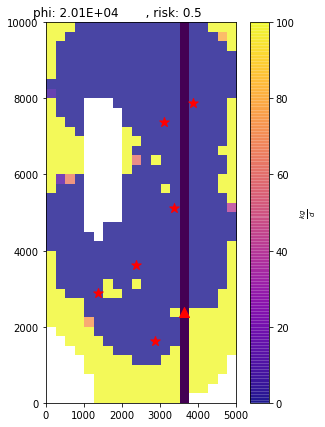

In [2]:
ouu_freyberg.run_scenario()